In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from imblearn.datasets import fetch_datasets
from pathlib import Path
sys.path.append(str(Path.cwd().parents[1]))
from handle_results import HandleResults
from handle_data import HandleData
from evaluate_oversampler_cross_val import CrossValidation
from sklearn.metrics import auc

In [2]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC, SVMSMOTE, ADASYN, BorderlineSMOTE
from sv_synthsonic import synthsonic
import smote_variants as sv

from xgboost.sklearn import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [3]:
HR = HandleResults()
HD = HandleData()
CV = CrossValidation()

In [4]:
home_folder = Path.cwd().parents[1]
plot_folder = home_folder.joinpath(home_folder, 'Plots')
path = home_folder.joinpath(home_folder, 'CSV_results')
df_info = pd.read_csv(path.joinpath('dataset_info.csv'))
df = pd.read_csv(path.joinpath('Cross_validation', 'Cross_validation.csv'), index_col=0)

# sizes

In [5]:
df_info.sort_values('size').head()

,dataset,size,features,numerical_features,categorical_features,majority,minority,type,imbalance_ratio
0,ecoli,336.0,7.0,5.0,2.0,301.0,35.0,mixed,0.116279
12,libras_move,360.0,90.0,90.0,0.0,336.0,24.0,numerical,0.071429
15,arrhythmia,452.0,278.0,137.0,141.0,427.0,25.0,mixed,0.058548
6,spectrometer,531.0,93.0,93.0,0.0,486.0,45.0,numerical,0.092593
17,oil,937.0,49.0,39.0,10.0,896.0,41.0,mixed,0.045759


# performance on small datasets

In [6]:
datasets = ['ecoli', 'libras_move', 'arrhythmia', 'spectrometer', 'oil']
random_state = 5
oversamplers = [ ADASYN(random_state=random_state, n_jobs=-1)
               , BorderlineSMOTE(random_state=random_state, n_jobs=-1)
               , sv.NoSMOTE()
               , RandomOverSampler(random_state=random_state)
               , sv.Random_SMOTE(random_state=random_state)
               , SMOTE(random_state=random_state, n_jobs=-1)
               , SVMSMOTE(random_state=random_state, n_jobs=-1)
               , sv.polynom_fit_SMOTE(random_state=random_state)
               , synthsonic(distinct_threshold=20)
               ]
proportions=np.array([0.2,0.4,0.6,0.8,1.])
oversampler_names = [ 'ADASYN'
                    , 'BorderlineSMOTE'
                    , 'NoOversampling'
                    , 'RandomOversampler'
                    , 'Random_SMOTE'
                    , 'SMOTE'
                    , 'SVMSMOTE'
                    , 'polynom_fit_SMOTE'
                    , 'synthsonic'
                    ]

# Functions

In [7]:
def get_pr(X,y, o, proportion) :
    pr, rc, thr = CV.calculate_pr_curve(X,y,name,o,proportion)
    aucscore = auc(rc,pr).round(3)
    
    return pr, rc, thr, aucscore

In [8]:
def get_props(df, name) :
    
    return HR.select_best(df, 'pr_auc').loc[ (df.dataset==name)&(df.oversampler!='SMOTENC')
                                 ,['oversampler','proportion']].sort_values('oversampler')['proportion']

In [9]:
def calc_pr_auc(X,y, oversamplers, props) :
    
    precisions = []
    recalls = []
    aucscores = []
    for oversampler, prop in zip(oversamplers, props) :
        pr, rec, _, aucscore = get_pr(X,y, oversampler, prop)
        precisions.append(pr)
        recalls.append(rec)
        aucscores.append(aucscore)
        
    return precisions, recalls, aucscores

In [10]:
def plot_pr(name, precisions, recalls, aucscores, oversampler_names) :
    fig, ax = plt.subplots(figsize=(12,7))
    ax.set_title(f'PR curve for {name}')
    ax.set_xlabel("Recall")
    ax.set_ylabel('Precision')

    for precision, recall, aucscore, oversampler in zip(precisions, recalls, aucscores, oversampler_names) :
        ax.plot(recall, precision, label=f'{oversampler} AUC = {aucscore}')

    ax.legend()

In [11]:
def plot_pcas(X,y, oversamplers, oversampler_names, props) :
    
    for oversampler, ovname, prop in zip(oversamplers, oversampler_names, props) :
        oversampler = CV.configure_oversampler(df_info, oversampler, prop)
        X_g,y_g = CV.generate_from_oversampler(oversampler, X,y)
        HD.pca_plot(X_g,y_g, title=f"2 component PCA: {ovname} {prop}")
        plt.show()

# Ecoli

In [12]:
X,y,name = HD.load_data('ecoli')
props = get_props(df, name)
df_info = HD.analyse_dataset(X,y,name, props)

In [13]:
ecoli_prs, ecoli_recs, ecoli_aucs = calc_pr_auc(X,y,oversamplers, props)

2021-08-30 15:11:59,482:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 15:11:59,482:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 15:11:59,552:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 15:11:59,552:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 15:11:59,606:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 15:11:59,606:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 15:11:59,655:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 15:11:59,655:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 15:11:59,877:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 0.4, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-08-30 15:11:59,877:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 0.4, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-08-30 15:11:59,954:INFO:Random_SMOTE: Running sampling via ('Random_SMO

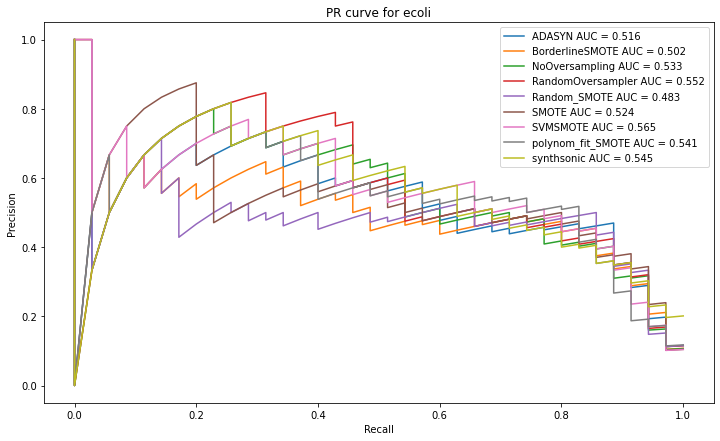

In [14]:
plot_pr(name, ecoli_prs, ecoli_recs, ecoli_aucs, oversampler_names)

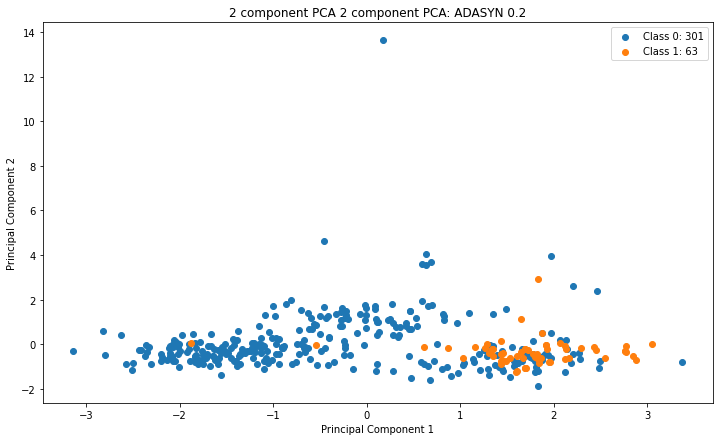

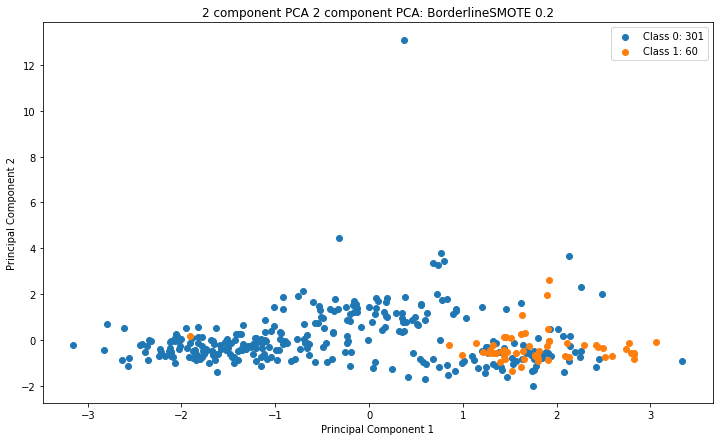

2021-08-30 15:12:15,706:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 15:12:15,706:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')


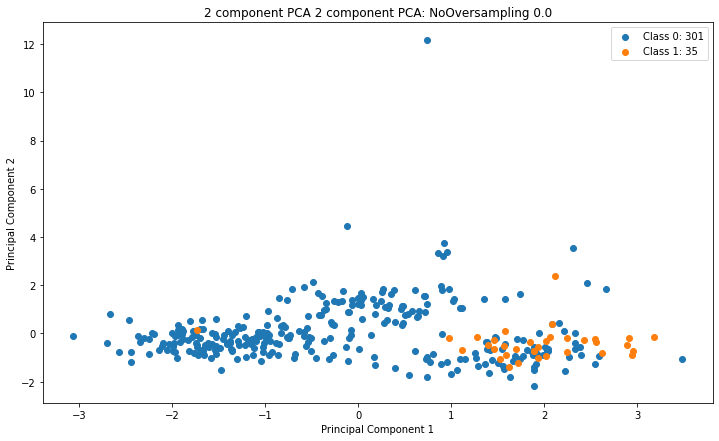

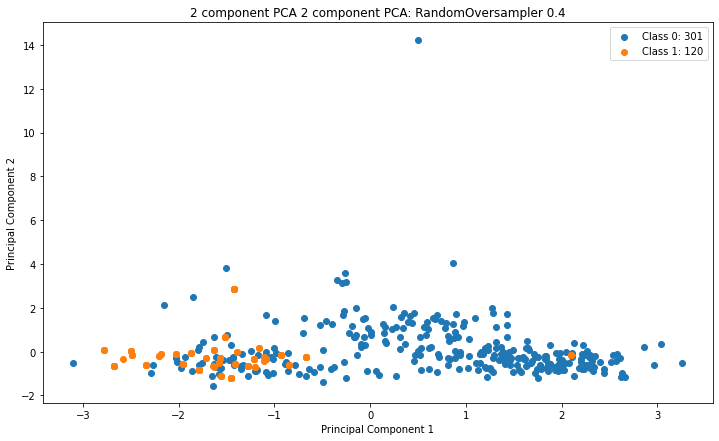

2021-08-30 15:12:16,010:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 0.4, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-08-30 15:12:16,010:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 0.4, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")


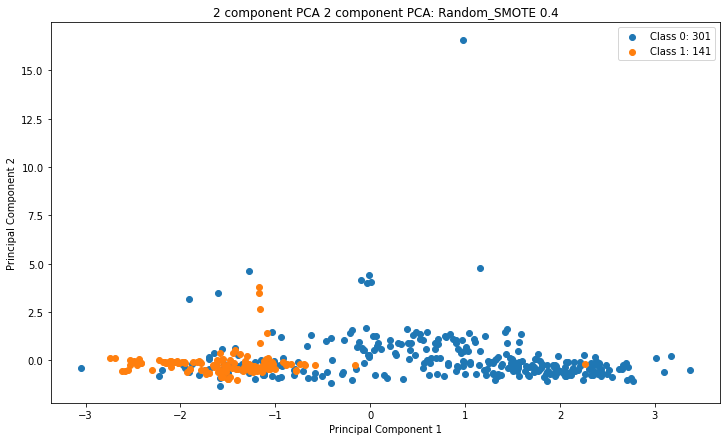

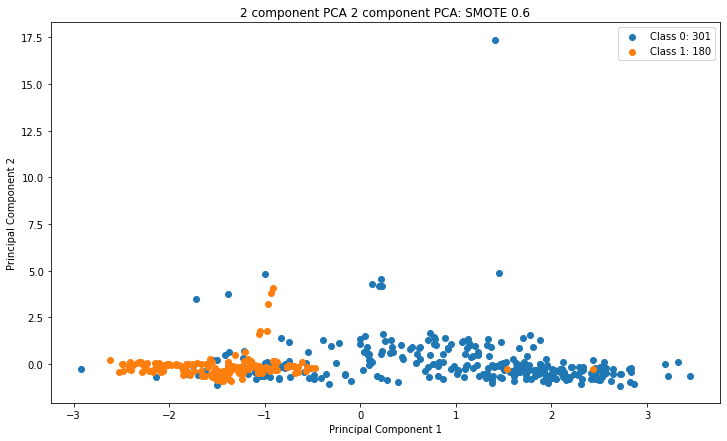

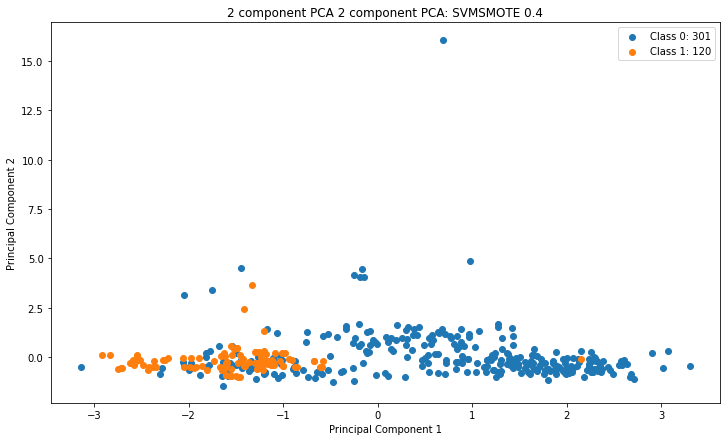

2021-08-30 15:12:16,672:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.8, 'topology': 'star', 'random_state': 5}")
2021-08-30 15:12:16,672:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.8, 'topology': 'star', 'random_state': 5}")


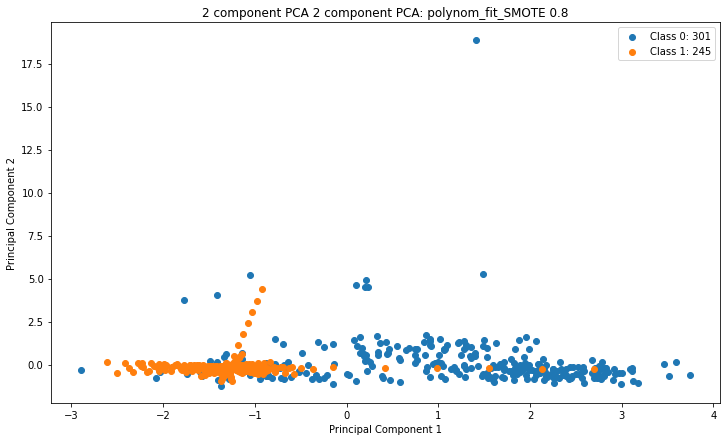

2021-08-30 15:12:16,827:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 1.0, 'distinct_threshold': 20, 'do_PCA': True, 'ordering': 'pca'}")
2021-08-30 15:12:16,827:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 1.0, 'distinct_threshold': 20, 'do_PCA': True, 'ordering': 'pca'}")
n_quantiles (500) is greater than the total number of samples (35). n_quantiles is set to num samples.
Building tree: 100%|██████████| 15/15.0 [00:00<00:00, 909.13it/s]
Generating for node: 2:  29%|██▊       | 2/7 [00:00<00:00, 11.05it/s]/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:522: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  "Found unknown state name. Trying to switch to using all state names as state numbers"
Generating for node: 5: 100%|██████████| 7/7 [00:00<00:00, 19.45it/s]


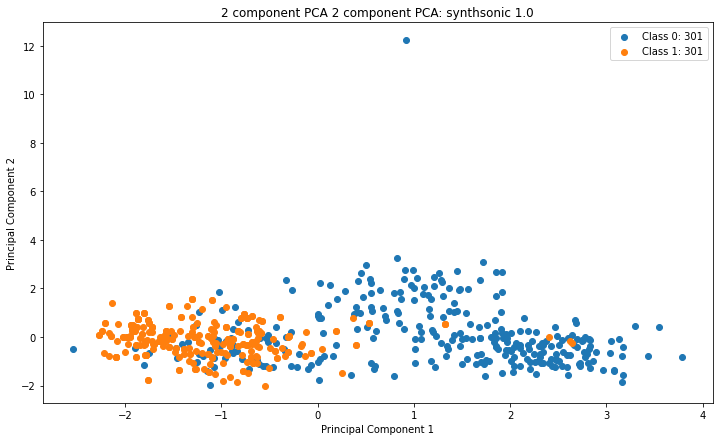

In [15]:
plot_pcas(X,y, oversamplers, oversampler_names, props)

# Libras move

In [16]:
X,y,name = HD.load_data('libras_move')
props = get_props(df, name)
df_info = HD.analyse_dataset(X,y,name, props)

In [17]:
libras_prs, libras_recs, libras_aucs = calc_pr_auc(X,y,oversamplers, props)

2021-08-30 15:12:22,556:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 15:12:22,556:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 15:12:22,633:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 15:12:22,633:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 15:12:22,705:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 15:12:22,705:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 15:12:22,781:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 15:12:22,781:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 15:12:23,187:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-08-30 15:12:23,187:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-08-30 15:12:23,305:INFO:Random_SMOTE: Running sampling via ('Random_SMO

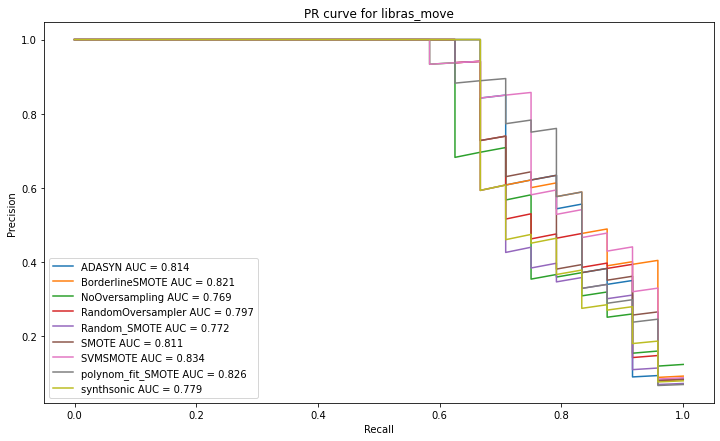

In [18]:
plot_pr(name, libras_prs, libras_recs, libras_aucs, oversampler_names)

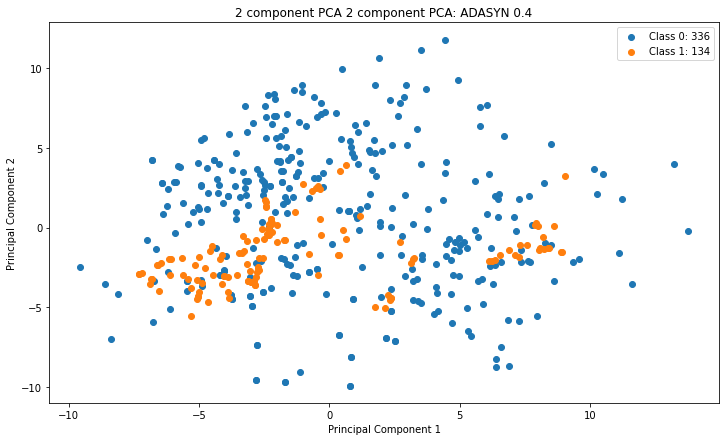

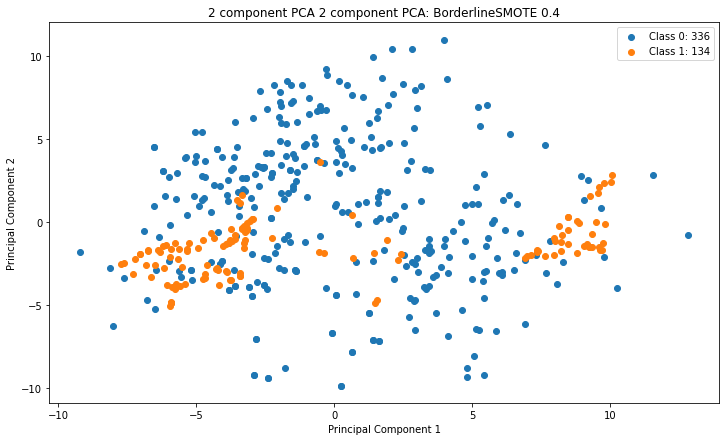

2021-08-30 15:15:34,097:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 15:15:34,097:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')


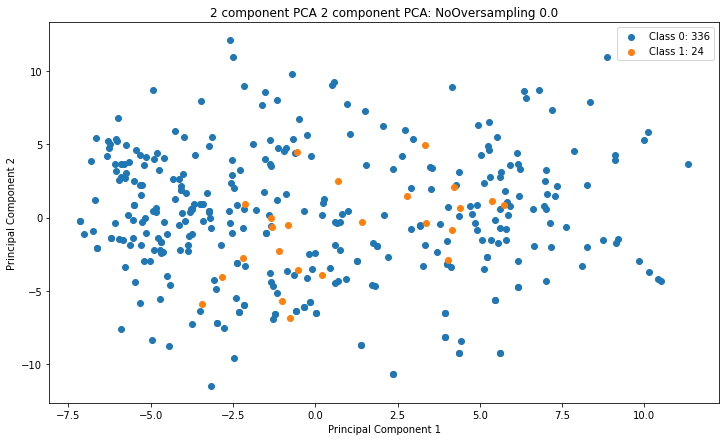

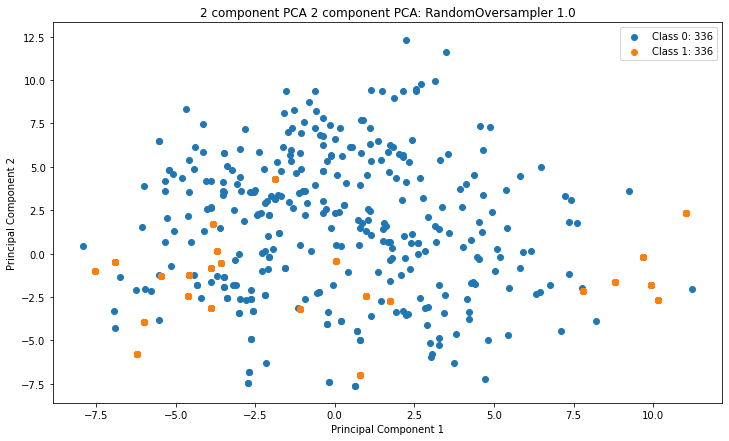

2021-08-30 15:15:34,432:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-08-30 15:15:34,432:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")


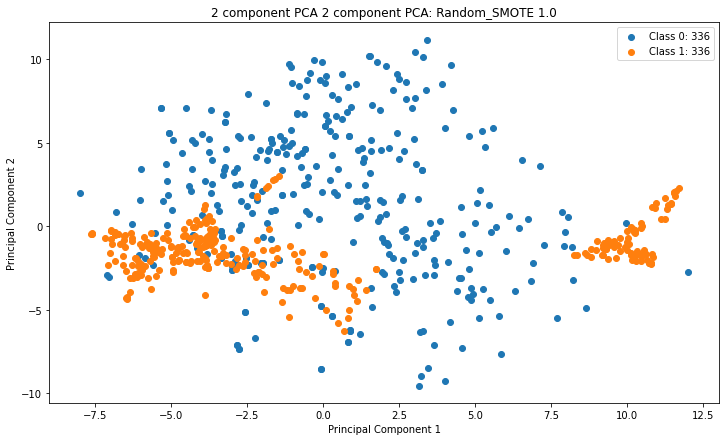

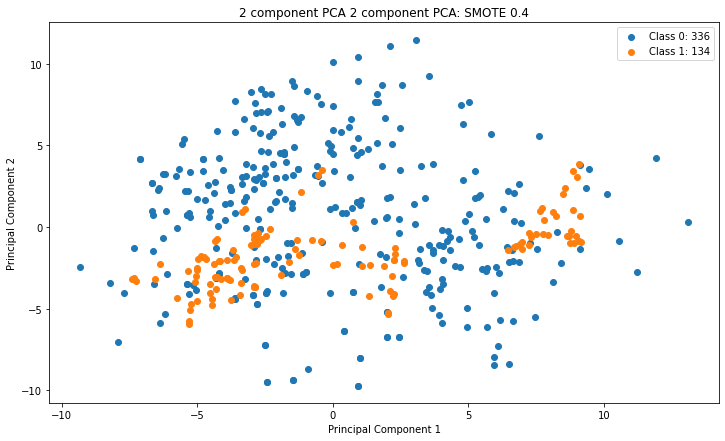

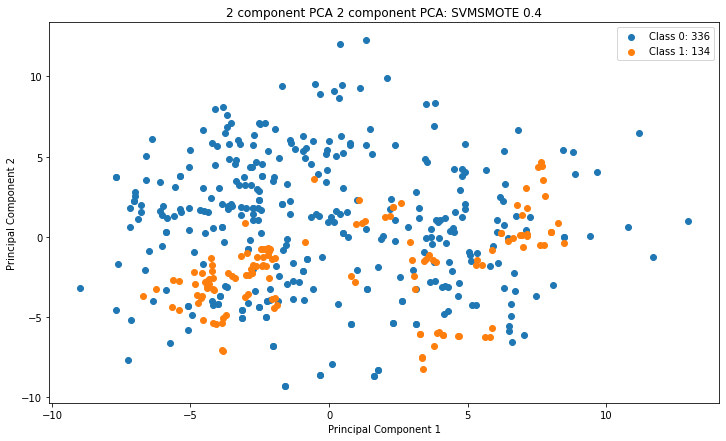

2021-08-30 15:15:35,145:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.6, 'topology': 'star', 'random_state': 5}")
2021-08-30 15:15:35,145:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.6, 'topology': 'star', 'random_state': 5}")


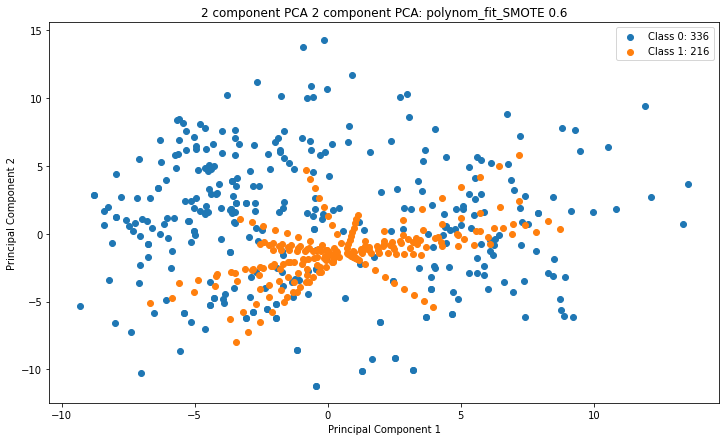

2021-08-30 15:15:35,318:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 1.0, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
2021-08-30 15:15:35,318:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 1.0, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
n_quantiles (500) is greater than the total number of samples (24). n_quantiles is set to num samples.
Building tree: 100%|██████████| 3916/3916.0 [00:04<00:00, 908.68it/s]
Generating for node: 0:   1%|          | 1/90 [00:01<02:41,  1.82s/it]/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:522: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  "Found unknown state name. Trying to switch to using all state names as state numbers"
Generating for node: 2: 100%|██████████| 90/90 [00:05<00:00, 15.49it/s] 


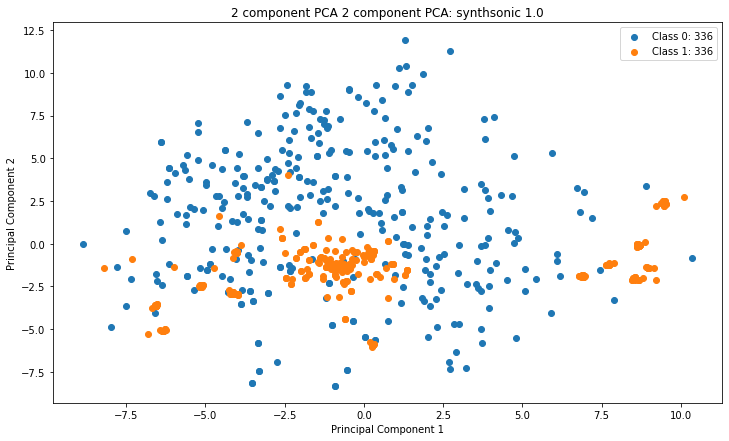

In [19]:
plot_pcas(X,y, oversamplers, oversampler_names, props)

# arrhythmia

In [20]:
X,y,name = HD.load_data('arrhythmia')
props = get_props(df, name)
df_info = HD.analyse_dataset(X,y,name, props)

In [21]:
arrhythmia_prs, arrhythmias_recs, arrhythmia_aucs = calc_pr_auc(X,y,oversamplers, props)

2021-08-30 15:16:34,694:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 15:16:34,694:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 15:16:34,769:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 15:16:34,769:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 15:16:34,844:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 15:16:34,844:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 15:16:34,914:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 15:16:34,914:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 15:16:35,245:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-08-30 15:16:35,245:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-08-30 15:16:35,366:INFO:Random_SMOTE: Running sampling via ('Random_SMO

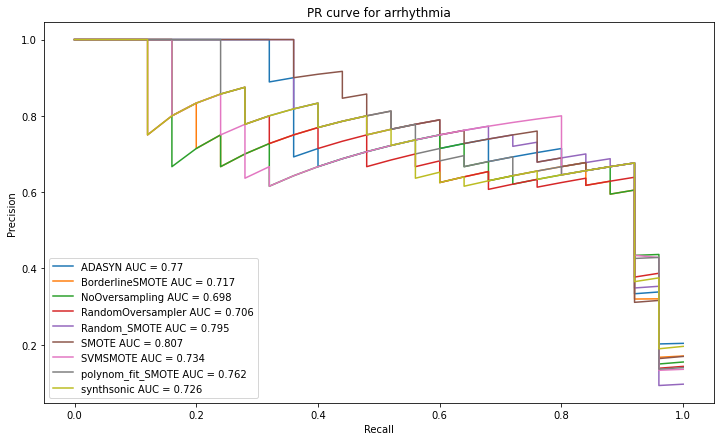

In [24]:
plot_pr(name, arrhythmia_prs, arrhythmias_recs, arrhythmia_aucs, oversampler_names)

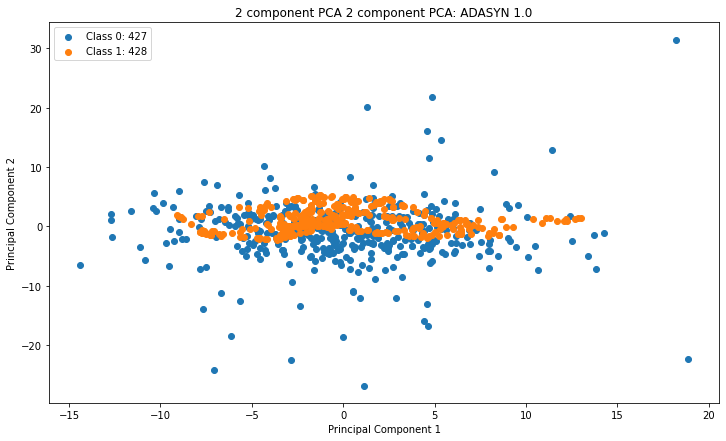

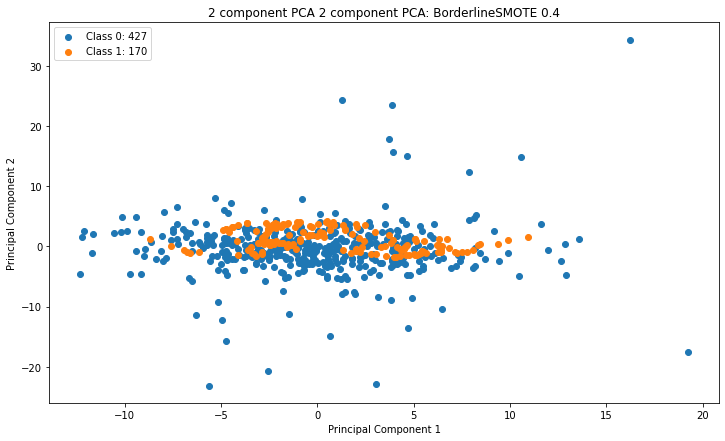

2021-08-30 15:42:34,067:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 15:42:34,067:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')


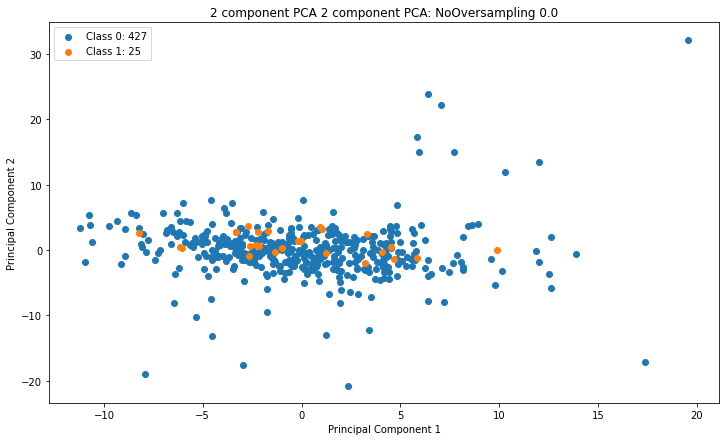

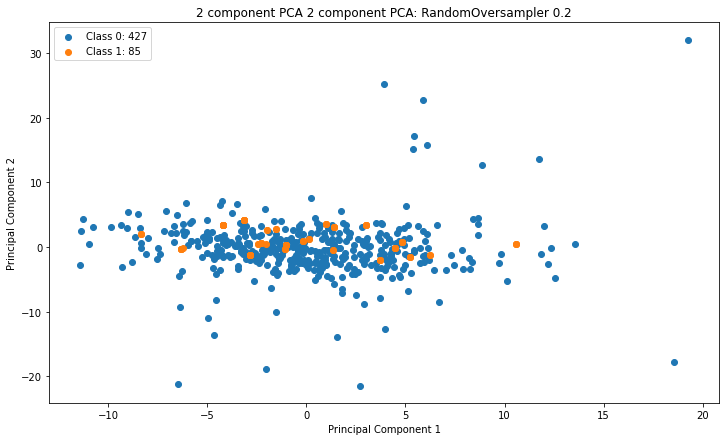

2021-08-30 15:42:34,587:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-08-30 15:42:34,587:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")


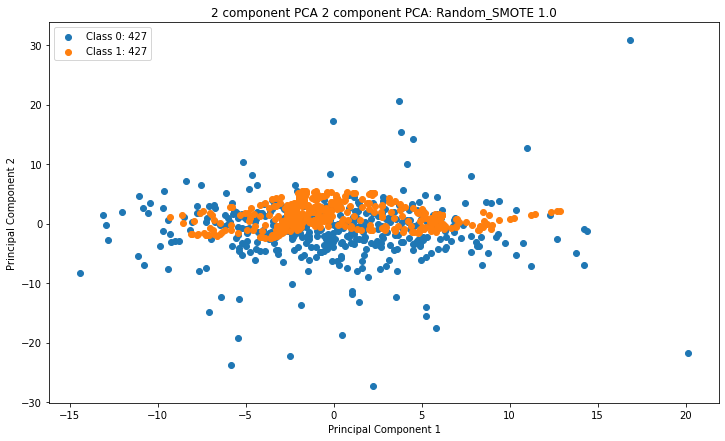

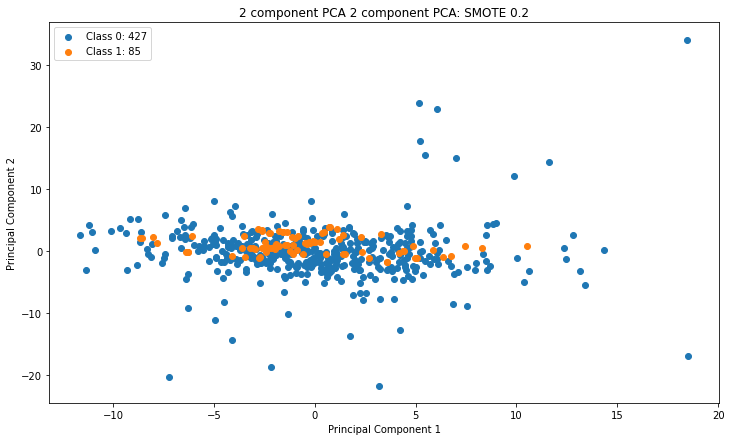

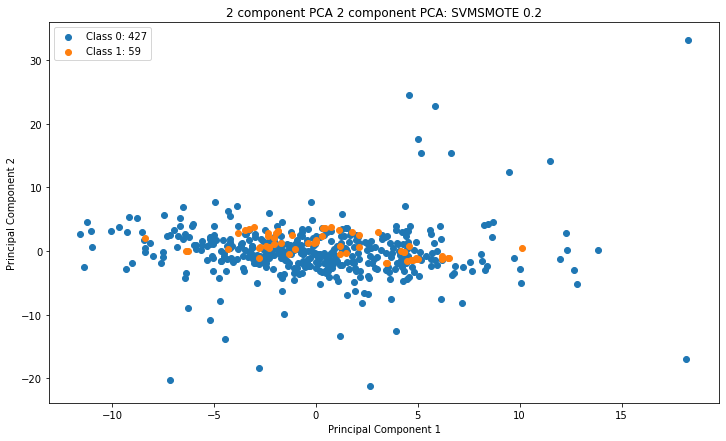

2021-08-30 15:42:35,516:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.4, 'topology': 'star', 'random_state': 5}")
2021-08-30 15:42:35,516:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.4, 'topology': 'star', 'random_state': 5}")


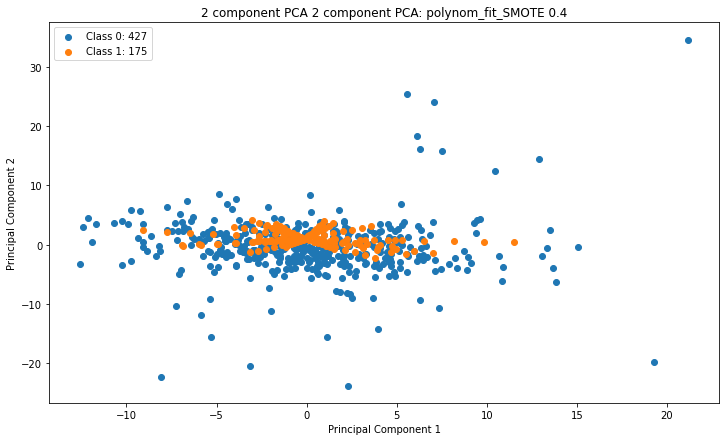

2021-08-30 15:42:35,701:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.8, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
2021-08-30 15:42:35,701:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.8, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
n_quantiles (500) is greater than the total number of samples (25). n_quantiles is set to num samples.
Building tree: 100%|██████████| 38226/38226.0 [00:41<00:00, 926.61it/s] 
Generating for node: 81:   4%|▍         | 11/278 [00:13<03:33,  1.25it/s] /Users/tristenmarto/anaconda3/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:522: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  "Found unknown state name. Trying to switch to using all state names as state numbers"
Generating for node: 2: 100%|██████████| 278/278 [00:02<00:00, 124.48it/s]  


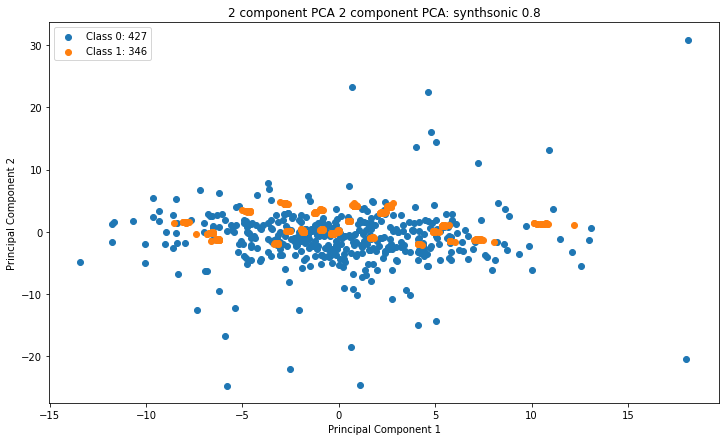

In [25]:
plot_pcas(X,y, oversamplers, oversampler_names, props)

# spectrometer

In [26]:
X,y,name = HD.load_data('spectrometer')
props = get_props(df, name)
df_info = HD.analyse_dataset(X,y,name, props)

In [27]:
spectrometer_prs, spectrometer_recs, spectrometer_aucs = calc_pr_auc(X,y,oversamplers, props)

2021-08-30 15:46:31,483:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 15:46:31,483:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 15:46:31,565:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 15:46:31,565:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 15:46:31,640:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 15:46:31,640:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 15:46:31,715:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 15:46:31,715:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 15:46:32,086:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 0.2, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-08-30 15:46:32,086:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 0.2, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-08-30 15:46:32,156:INFO:Random_SMOTE: Running sampling via ('Random_SMO

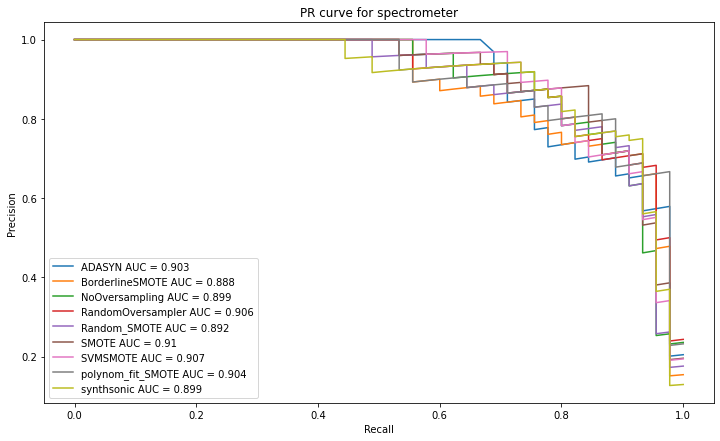

In [29]:
plot_pr(name, spectrometer_prs, spectrometer_recs, spectrometer_aucs, oversampler_names)

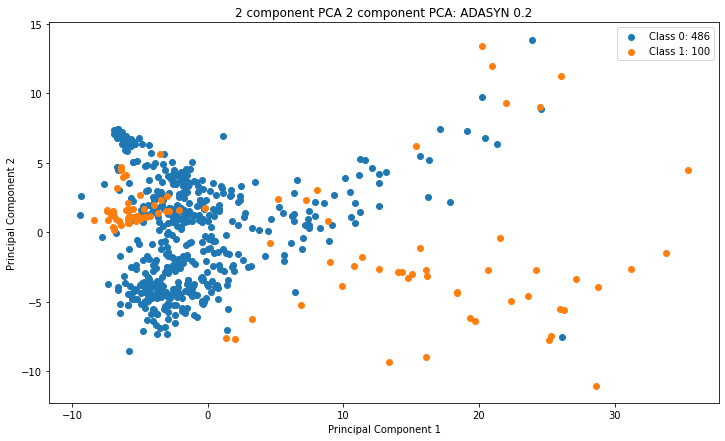

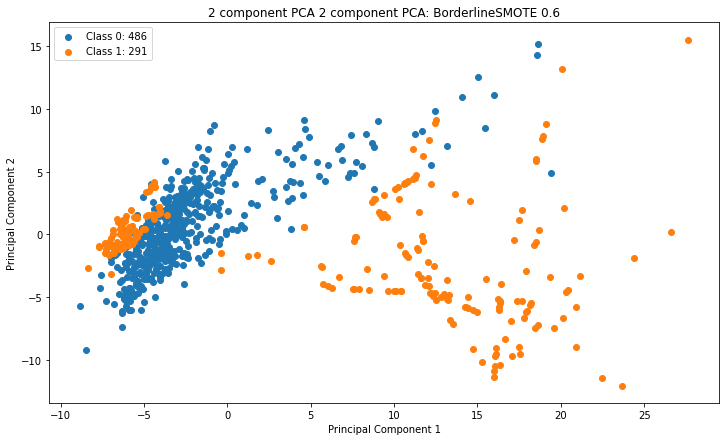

2021-08-30 15:53:47,299:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 15:53:47,299:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')


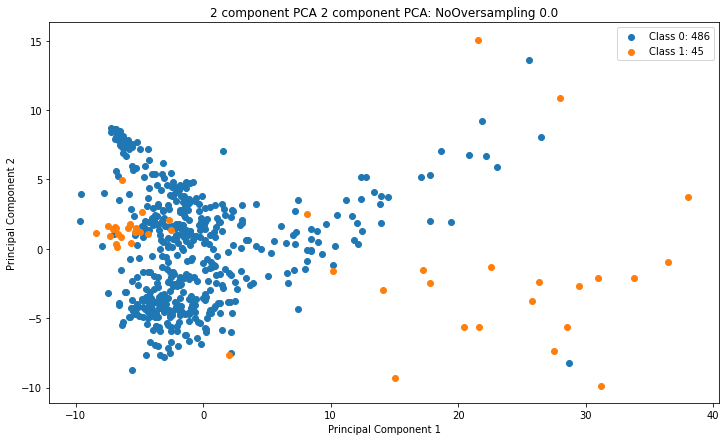

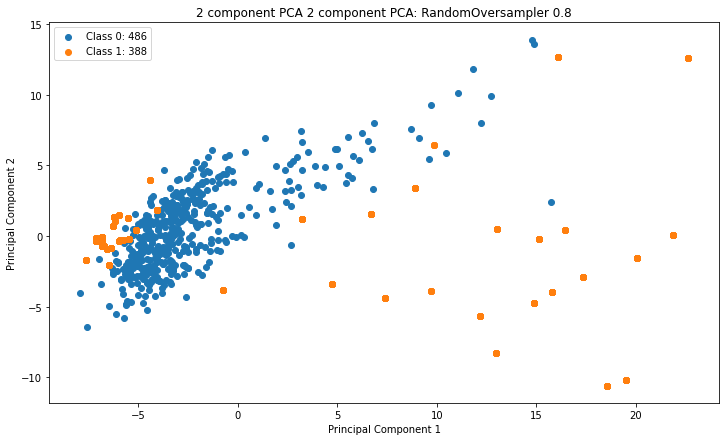

2021-08-30 15:53:47,697:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 0.2, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-08-30 15:53:47,697:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 0.2, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")


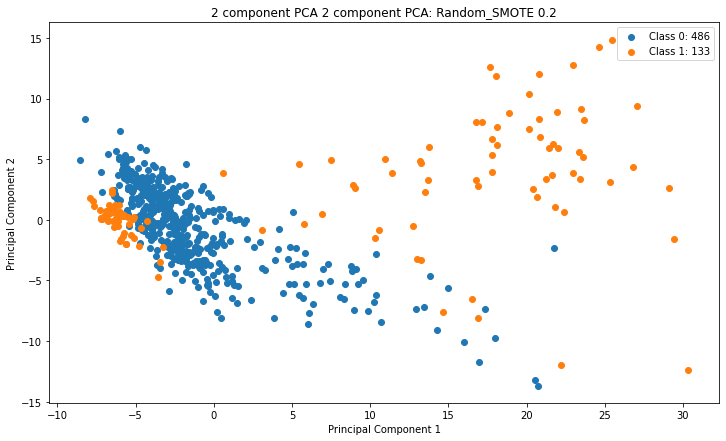

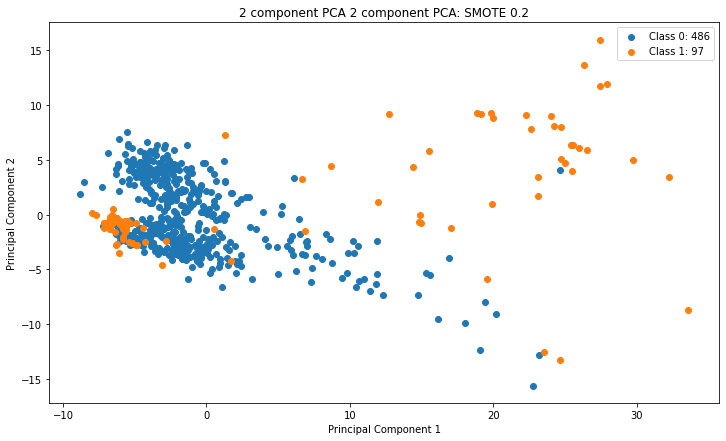

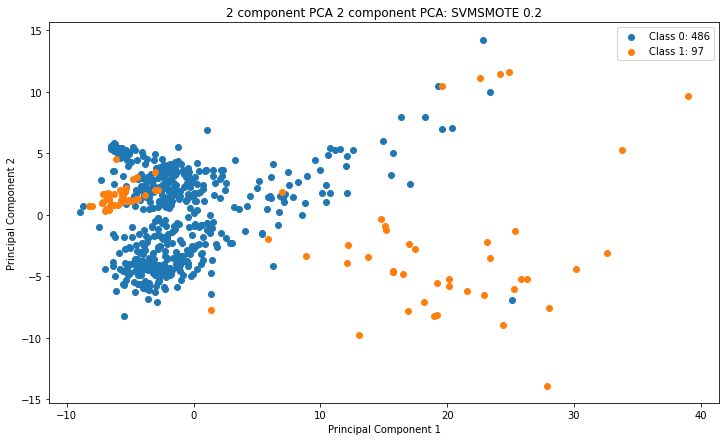

2021-08-30 15:53:48,512:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.2, 'topology': 'star', 'random_state': 5}")
2021-08-30 15:53:48,512:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.2, 'topology': 'star', 'random_state': 5}")


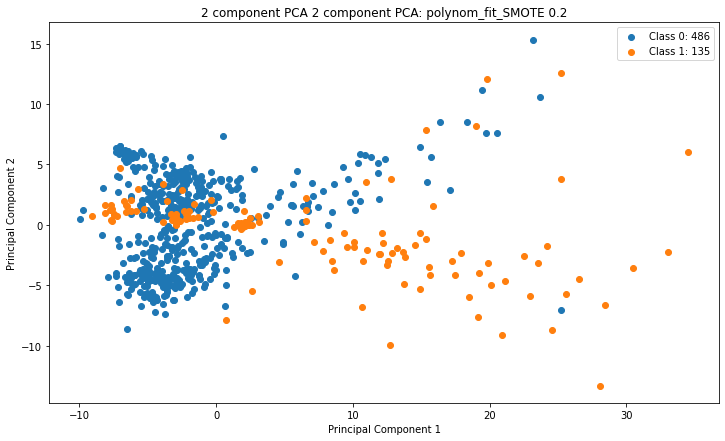

2021-08-30 15:53:48,683:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.6, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
2021-08-30 15:53:48,683:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.6, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
n_quantiles (500) is greater than the total number of samples (45). n_quantiles is set to num samples.
Building tree: 100%|██████████| 4186/4186.0 [00:04<00:00, 909.57it/s]
Generating for node: 2: 100%|██████████| 93/93 [00:06<00:00, 14.34it/s] 


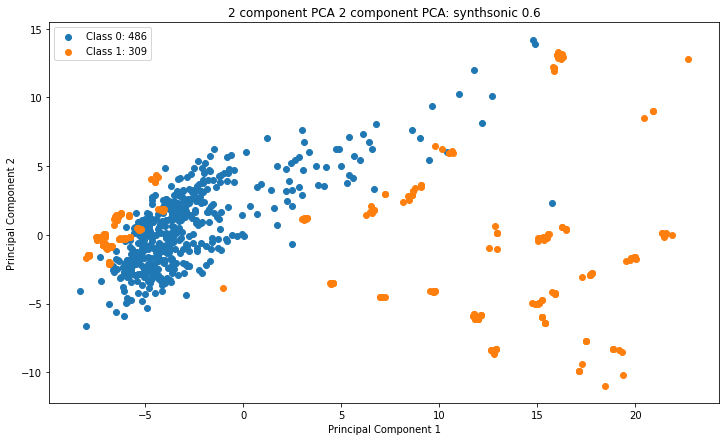

In [30]:
plot_pcas(X,y, oversamplers, oversampler_names, props)

# oil

In [31]:
X,y,name = HD.load_data('oil')
props = get_props(df, name)
df_info = HD.analyse_dataset(X,y,name, props)

In [32]:
oil_prs, oil_recs, oil_aucs = calc_pr_auc(X,y,oversamplers, props)

2021-08-30 15:54:52,817:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 15:54:52,817:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 15:54:52,960:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 15:54:52,960:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 15:54:53,097:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 15:54:53,097:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 15:54:53,223:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 15:54:53,223:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 15:54:53,838:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 0.8, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-08-30 15:54:53,838:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 0.8, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-08-30 15:54:54,039:INFO:Random_SMOTE: Running sampling via ('Random_SMO

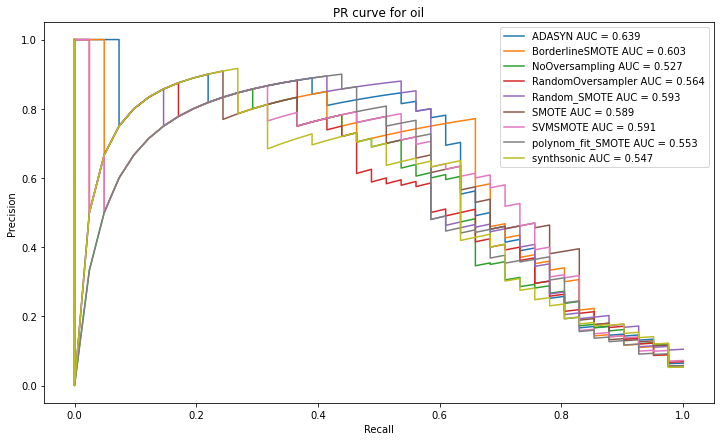

In [33]:
plot_pr(name, oil_prs, oil_recs, oil_aucs, oversampler_names)

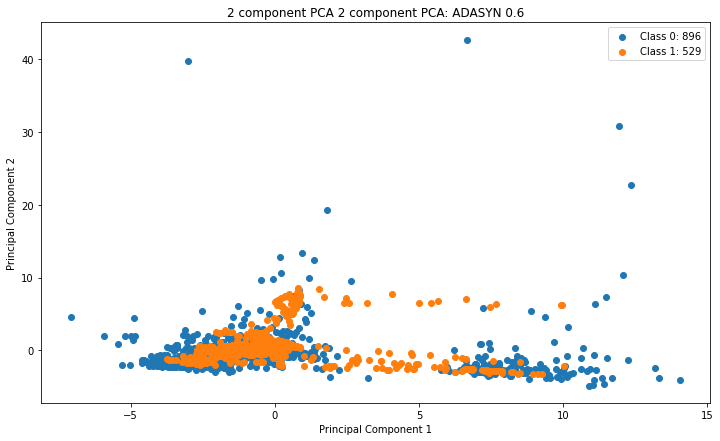

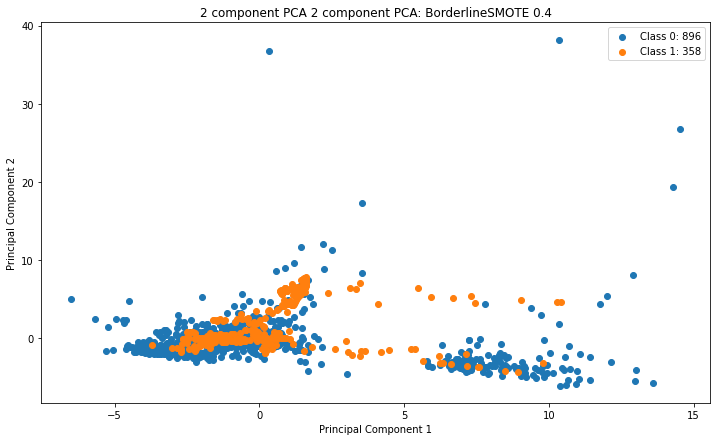

2021-08-30 15:56:42,240:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 15:56:42,240:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')


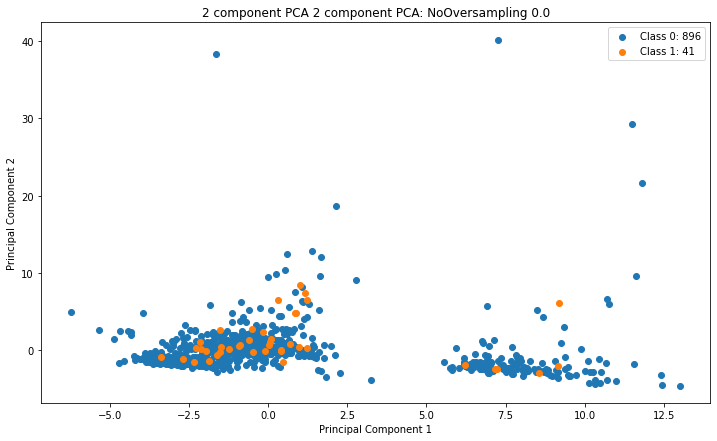

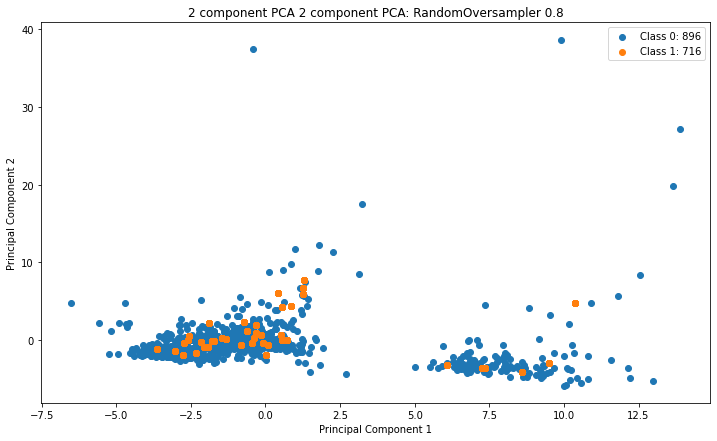

2021-08-30 15:56:42,666:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 0.8, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-08-30 15:56:42,666:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 0.8, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")


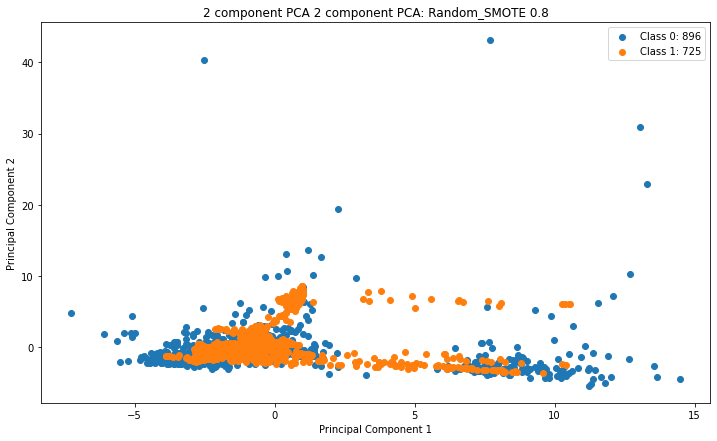

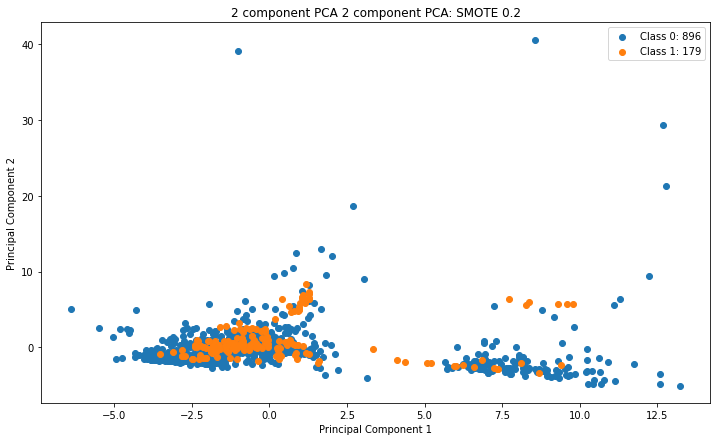

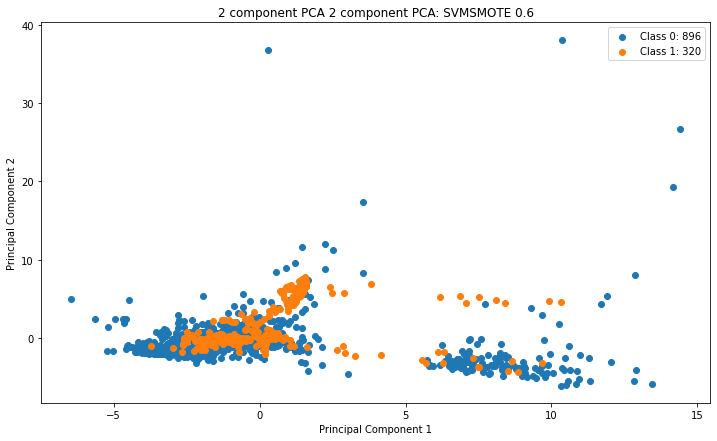

2021-08-30 15:56:43,419:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.4, 'topology': 'star', 'random_state': 5}")
2021-08-30 15:56:43,419:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.4, 'topology': 'star', 'random_state': 5}")


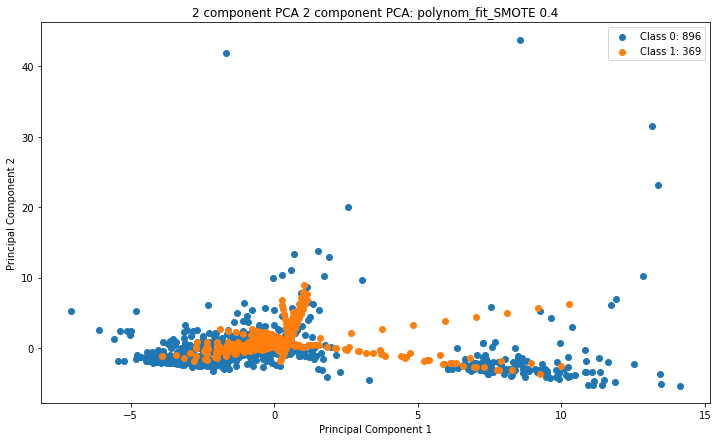

2021-08-30 15:56:43,582:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 1.0, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
2021-08-30 15:56:43,582:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 1.0, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
n_quantiles (500) is greater than the total number of samples (41). n_quantiles is set to num samples.
Building tree: 100%|██████████| 1128/1128.0 [00:01<00:00, 1035.95it/s]
Generating for node: 25:  24%|██▍       | 12/49 [00:03<00:10,  3.68it/s]/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:522: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  "Found unknown state name. Trying to switch to using all state names as state numbers"
Generating for node: 34: 100%|██████████| 49/49 [00:02<00:00, 16.74it/s]


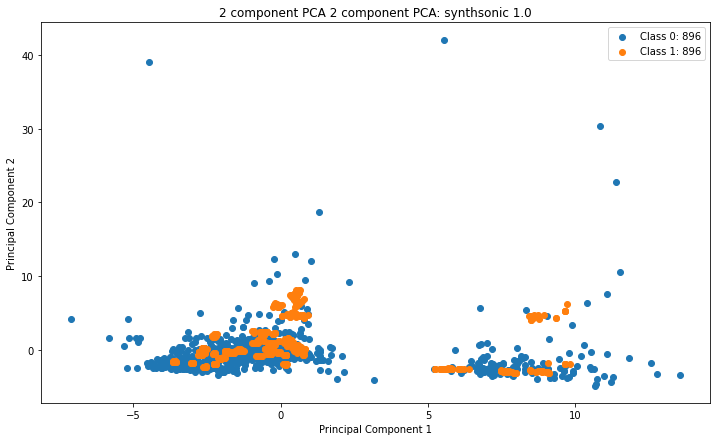

In [34]:
plot_pcas(X,y, oversamplers, oversampler_names, props)